In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [3]:
import lifetimes

In [4]:
import lifetimes.plotting

In [5]:
from datetime import datetime

In [6]:
from sklearn.metrics import mean_absolute_error,confusion_matrix

In [7]:
import seaborn as sns

In [8]:
conn=sqlite3.connect("TitosTrans.sqlite")
TitosTrans=pd.read_sql('SELECT * FROM TitosTrans', conn)
TitosTrans.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters),Invoice/Item Number,Store Number,Store Name
0,2020-02-03 00:00:00,USVodka,titos handmade vodka,171.00,10.50,INV-24978400002,4116,lake view foods
1,2020-11-03 00:00:00,USVodka,titos handmade vodka,228.12,12.00,INV-31637100031,4019,wal mart 1506 manchester
2,2019-07-18 00:00:00,USVodka,titos handmade vodka,16.26,0.75,INV-20706400109,3456,quick shop clear lake
3,2019-07-09 00:00:00,USVodka,titos handmade vodka,173.52,9.00,INV-20507500004,3742,wal mart 1625 lemars
4,2019-07-22 00:00:00,USVodka,titos handmade vodka,1735.20,90.00,INV-20748500037,2528,hy vee food store 3 des moines


In [9]:
TitosTrans['Date']= pd.to_datetime(TitosTrans['Date'])

For CLV Predictions, we will use the time frame between 2018 and 2021

In [10]:
TitosTransCLV=TitosTrans[TitosTrans['Date'] >= '2018-01-01']
TitosTransCLV.shape

(141589, 8)

In [11]:
max(TitosTransCLV.Date)

Timestamp('2021-01-29 00:00:00')

In [12]:
min(TitosTransCLV.Date)

Timestamp('2018-01-02 00:00:00')

Divide into train and validation sets. Train set contains about 6 inter-purchase periods (2 years). Validation set is half the period of the train set (1 year).

In [13]:
train=TitosTransCLV[TitosTransCLV['Date'] < '2020-01-01']
train.shape

(82407, 8)

In [14]:
test=TitosTransCLV[TitosTransCLV['Date'] >= '2020-01-01']
test.shape

(59182, 8)

Beta Geometry/Negative Binomial Distribution (BG/NBD) is a probabilistic prediction model that fits the distribution of the customer transaction data and then predict the probability of the life of a customer, number of transactions and sales.

- When a user is active, a number of his or her transactions in a time period of length t is described by Poisson distribution with transaction rate λ.
- Heterogeneity in transaction rate across users (meaning how customers differ in purchasing behavior) has Gamma distribution with parameters r (shape) and α (scale).
- Users may become inactive after any transaction with probability p and their dropout point (when they become inactive) is distributed between purchases with Geometric distribution.
- Heterogeneity (variation across users) in dropout probability has Beta distribution with the two shape parameters α and β.

Create an RFM table. Recency definition is different that the definition we used earlier. In BG/NBD model, it is the period between the first transaction and the last transaction made by a customer.

- frequency — the number of repeat purchases (more than 1 purchases)
- recency — the time between the first and the last transaction
- T — the time between the first purchase and the end of the transaction period (last date of the time frame considered for the analysis)
- monetary_value — it is the mean of a given customers sales value

In [15]:
summary=lifetimes.utils.summary_data_from_transaction_data(train,'Store Number','Date','Sale (Dollars)').reset_index()
summary.head()

,Store Number,frequency,recency,T,monetary_value
0,2106,98.0,722.0,726.0,1120.656327
1,2113,73.0,727.0,728.0,105.920959
2,2130,99.0,722.0,726.0,936.481616
3,2178,60.0,693.0,704.0,342.230000
4,2190,172.0,722.0,726.0,230.643140


In [16]:
# exclude all the stores that are listed but made zero transactions
summary=summary[summary['frequency']>0]

Lets look at the frequency distribution

<AxesSubplot:ylabel='Frequency'>

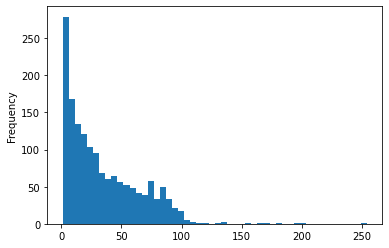

In [17]:
summary['frequency'].plot(kind='hist',bins=50)

In [18]:
summary['frequency'].describe()

count    1562.000000
mean       34.289373
std        30.153496
min         1.000000
25%        10.000000
50%        25.000000
75%        53.750000
max       254.000000
Name: frequency, dtype: float64

Fit BG/NBD model on the summary data.

In [19]:
bgf=lifetimes.BetaGeoFitter(penalizer_coef=0)
bgf.fit(summary['frequency'],summary['recency'],summary['T'])

<lifetimes.BetaGeoFitter: fitted with 1562 subjects, a: 0.03, alpha: 33.05, b: 6.46, r: 1.78>

- r and alpha are the paramters of the fitted Gamma distribution that fits the distribution of the transaction rates.
- a and b are the parameters for the fitted Beta distribution that fits the distribution of the difference in the dropout probability across customers.

In [20]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.778693,0.066912,1.647545,1.909840
alpha,33.052068,1.388697,30.330222,35.773915
a,0.033060,0.008063,0.017256,0.048863
b,6.459003,2.955763,0.665708,12.252299


In [21]:
# predict the alive probability
summary['p_alive']=bgf.conditional_probability_alive(summary['frequency'],summary['recency'],summary['T'])
summary.head()

,Store Number,frequency,recency,T,monetary_value,p_alive
0,2106,98.0,722.0,726.0,1120.656327,0.999459
1,2113,73.0,727.0,728.0,105.920959,0.999535
2,2130,99.0,722.0,726.0,936.481616,0.999461
3,2178,60.0,693.0,704.0,342.230000,0.998723
4,2190,172.0,722.0,726.0,230.643140,0.999534


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

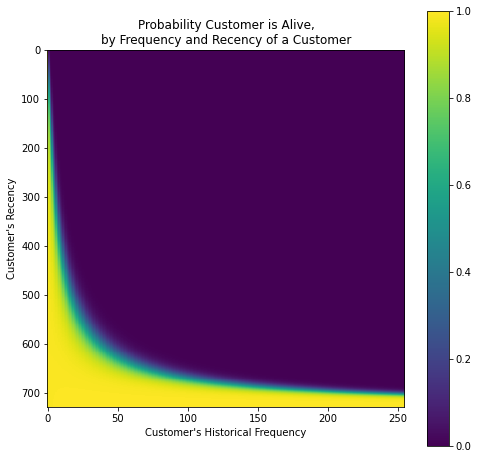

In [22]:
# now we can plot the probability
plt.rcParams['figure.figsize'] = (8,8)
lifetimes.plotting.plot_probability_alive_matrix(bgf)

In [23]:
# predict the future number of transaction from 1/1/2020 until 1/29/2021
t=(datetime(2021,1,29)-datetime(2020,1,1)).days
summary['pred_frequency']=bgf.conditional_expected_number_of_purchases_up_to_time(t,summary['frequency'],summary['recency'],summary['T'])
summary.head()

,Store Number,frequency,recency,T,monetary_value,p_alive,pred_frequency
0,2106,98.0,722.0,726.0,1120.656327,0.999459,51.394953
1,2113,73.0,727.0,728.0,105.920959,0.999535,38.422847
2,2130,99.0,722.0,726.0,936.481616,0.999461,51.910051
3,2178,60.0,693.0,704.0,342.230000,0.998723,32.745597
4,2190,172.0,722.0,726.0,230.643140,0.999534,89.509722


Now lets get the frequency in the test dataset and compare with the predicted frequency

In [24]:
summary_test=lifetimes.utils.summary_data_from_transaction_data(test,'Store Number','Date','Sale (Dollars)').reset_index()
summary_test.head()

,Store Number,frequency,recency,T,monetary_value
0,2106,48.0,391.0,392.0,1118.700000
1,2113,1.0,7.0,375.0,228.120000
2,2130,47.0,391.0,392.0,1208.800851
3,2178,39.0,364.0,385.0,392.141538
4,2190,119.0,382.0,382.0,239.025882


In [25]:
summary.shape

(1562, 7)

In [26]:
summary_test.shape

(1783, 5)

In [27]:
freq = pd.merge(summary[['Store Number','pred_frequency','p_alive']],summary_test[['Store Number','frequency']],on=['Store Number'],how='left')
freq.rename(columns={'frequency':'actual_frequency'},inplace=True)
freq.head()

,Store Number,pred_frequency,p_alive,actual_frequency
0,2106,51.394953,0.999459,48.0
1,2113,38.422847,0.999535,1.0
2,2130,51.910051,0.999461,47.0
3,2178,32.745597,0.998723,39.0
4,2190,89.509722,0.999534,119.0


In [28]:
freq.shape

(1562, 4)

In [29]:
# there are 144 stores that didn't make any transactions in the validation year of 2020
freq['actual_frequency'].isna().sum()

127

In [30]:
#There are 144 stores without any actual transactions in the 
freq[freq['actual_frequency'].isna()]

,Store Number,pred_frequency,p_alive,actual_frequency
12,2327,1.028291e-03,1.011579e-04,NaN
13,2448,2.527257e-10,1.194303e-11,NaN
16,2475,1.698506e+00,1.621394e-01,NaN
61,2564,8.613926e-05,2.467338e-05,NaN
184,3013,1.273474e+01,8.119434e-01,NaN
...,...,...,...,...
1451,5707,8.753339e+00,9.740863e-01,NaN
1472,5729,4.060711e+00,8.888603e-01,NaN
1475,5732,3.813354e+01,9.985415e-01,NaN
1483,5742,4.151094e+00,8.934466e-01,NaN


In [31]:
#The actual frequency will be filled as zero
freq.fillna(0,inplace=True)

Text(0, 0.5, 'Actual Transactions')

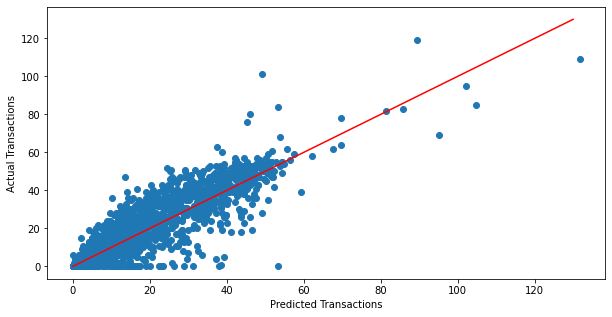

In [32]:
# actual vs. predicted
plt.rcParams['figure.figsize'] = (10,5)
plt.plot(freq['pred_frequency'],freq['actual_frequency'],'o')
plt.plot([0,130],[0,130],'r')
plt.xlabel('Predicted Transactions')
plt.ylabel('Actual Transactions')

In [33]:
mae=mean_absolute_error(freq['actual_frequency'], freq['pred_frequency'])
print('The MAE is',mae, 'transactions')

The MAE is 6.183192685554606 transactions


In [34]:
freq['actual_frequency'].mean()

21.420614596670934

Text(0.5, 1.0, 'Validation Period 2020')

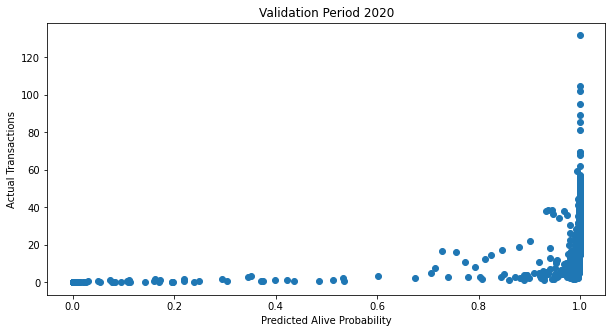

In [35]:
plt.plot(freq['p_alive'],freq['pred_frequency'],'o')
plt.xlabel('Predicted Alive Probability')
plt.ylabel('Actual Transactions')
plt.title('Validation Period 2020')

In [36]:
conn=sqlite3.connect("TitosStoreSegments.sqlite")
segments=pd.read_sql('SELECT * FROM TitosStoreSegments', conn)
segments.head()

,Store Number,Recency,Frequency,Sales,Store Segment
0,4116,11,60,11165.04,Medium
1,4019,3,299,68375.52,Medium
2,3456,1,608,182895.98,High
3,3742,3,218,48454.44,Medium
4,2528,1,286,213316.75,High


In [37]:
# find the segments of each of the stores with the prdicted transactions
freq_seg = pd.merge(freq,segments[['Store Number','Store Segment']],on=['Store Number'],how='left')
freq_seg.head()

,Store Number,pred_frequency,p_alive,actual_frequency,Store Segment
0,2106,51.394953,0.999459,48.0,High
1,2113,38.422847,0.999535,1.0,Medium
2,2130,51.910051,0.999461,47.0,High
3,2178,32.745597,0.998723,39.0,Medium
4,2190,89.509722,0.999534,119.0,High


In [38]:
freq_seg.shape

(1562, 5)

[Text(0.5, 0, 'Predicted Alive Probability'),
 Text(0, 0.5, 'Actual Transactions'),
 Text(0.5, 1.0, 'Validation Period 2020')]

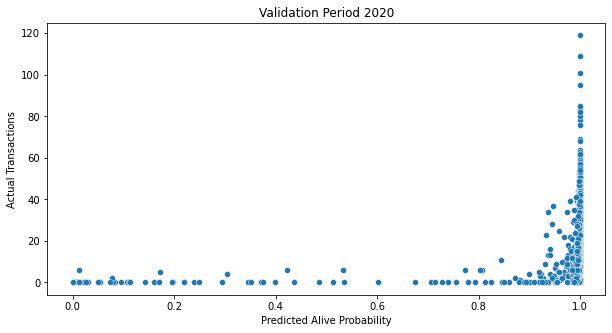

In [39]:
fig=sns.scatterplot(freq_seg['p_alive'],freq_seg['actual_frequency'])
fig.set(xlabel='Predicted Alive Probability', ylabel='Actual Transactions',title='Validation Period 2020')

In [373]:
# Determine Accuracy
freq_seg['pred_alive']=freq_seg['p_alive'].apply(lambda x:1 if x>=0.5 else 0)
freq_seg['actual_alive']=freq_seg['actual_frequency'].apply(lambda x:1 if x>0 else 0)
freq_seg.head()

,Store Number,pred_frequency,p_alive,actual_frequency,Store Segment,pred_alive,actual_alive
0,2106,51.394953,0.999459,48.0,High,1,1
1,2113,38.422847,0.999535,1.0,Medium,1,1
2,2130,51.910051,0.999461,47.0,High,1,1
3,2178,32.745597,0.998723,39.0,Medium,1,1
4,2190,89.509722,0.999534,119.0,High,1,1


Function to plot confusion matrix borrowed from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

In [281]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Actual')
        plt.xlabel('Predicted' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [374]:
cm=confusion_matrix(freq_seg['actual_alive'],freq_seg['pred_alive'])
cm

array([[  72,   76],
       [   5, 1409]], dtype=int64)

In [375]:
cm[:,1]

array([  76, 1409], dtype=int64)

In [376]:
freq_seg[freq_seg['actual_alive']==0].count()

Store Number        148
pred_frequency      148
p_alive             148
actual_frequency    148
Store Segment       148
pred_alive          148
actual_alive        148
dtype: int64

In [377]:
freq_seg[(freq_seg['actual_alive']==0) & (freq_seg['pred_alive']==1)].count()

Store Number        76
pred_frequency      76
p_alive             76
actual_frequency    76
Store Segment       76
pred_alive          76
actual_alive        76
dtype: int64

In [378]:
freq_seg[freq_seg['actual_alive']==1].count()

Store Number        1414
pred_frequency      1414
p_alive             1414
actual_frequency    1414
Store Segment       1414
pred_alive          1414
actual_alive        1414
dtype: int64

In [379]:
freq_seg[freq_seg['pred_alive']==0].count()

Store Number        77
pred_frequency      77
p_alive             77
actual_frequency    77
Store Segment       77
pred_alive          77
actual_alive        77
dtype: int64

In [380]:
freq_seg[freq_seg['pred_alive']==1].count()

Store Number        1485
pred_frequency      1485
p_alive             1485
actual_frequency    1485
Store Segment       1485
pred_alive          1485
actual_alive        1485
dtype: int64

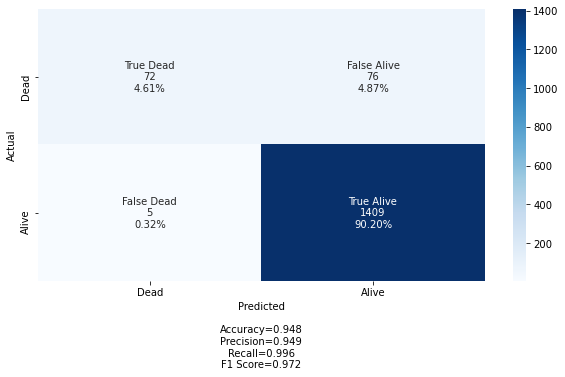

In [381]:
labels = ['True Dead','False Alive','False Dead','True Alive']
categories = ['Dead', 'Alive']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories)

93.5% of the correctly predicted alive stores are actually alive

In [382]:
# precisiion of being alive
1409/(1409+76)

0.9488215488215488

Out of all the actual alive stores 99.7% were predicted to be alive

In [383]:
# recall of being alive
1409/(1409+5)

0.9964639321074965

- The model is doing well to predict the probability of a store to be alive. This probability is important to make decisions on the allocation of the marketing costs.
- There is always a risk that money will be spent on a store that may become dead, and the probability of that risk is 4.87%.
- There is also a risk that we may ignore a store that will still be alive, and the probability of that risk is 0.3%.
- These percentages are small and can be considered as the risk cost of the marketing plan.

Looking at the segemnts of the stores that were predicted to be alive but they're actually dead. Some of them are in the low segement that stopped ordering by the end of 2018. Most are in the medium segment.

In [384]:
df=freq_seg[(freq_seg['actual_alive']==0) & (freq_seg['pred_alive']==1)][['Store Segment','Store Number']].groupby(['Store Segment']).nunique()
print (df)

               Store Number
Store Segment              
High                      1
Low                       4
Medium                   71


Now that the model is trained and validated, the validation period can be included in the fitting of the model to predict the probability for each customer for 2021. I am going to use the validated model with the whole period from Jan 2018 to Feb 2021 to predict the alive probability and the number of transaction in the next 90 days.

In [385]:
# get RFM for the three year period
summary_all=lifetimes.utils.summary_data_from_transaction_data(TitosTransCLV,'Store Number','Date','Sale (Dollars)').reset_index()
summary_all.head()

,Store Number,frequency,recency,T,monetary_value
0,2106,147.0,1120.0,1121.0,1120.153197
1,2113,75.0,755.0,1123.0,106.523600
2,2130,147.0,1120.0,1121.0,1029.593741
3,2178,100.0,1078.0,1099.0,361.718400
4,2190,292.0,1121.0,1121.0,234.979110


In [386]:
# Exclude the stores that are listed but reported zero transactions
summary_all=summary_all[summary_all['frequency']>0]

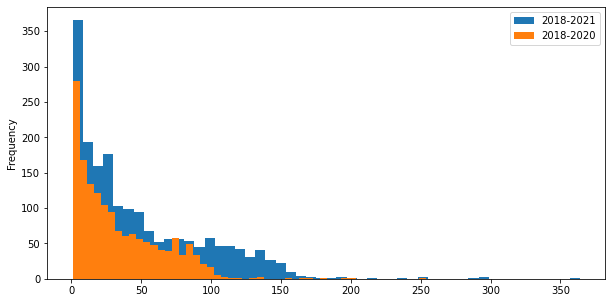

In [387]:
summary_all['frequency'].plot(kind='hist',bins=50, label='2018-2021')
summary['frequency'].plot(kind='hist',bins=50,label='2018-2020')
plt.legend()

In [388]:
summary_all['frequency'].describe()

count    1864.000000
mean       48.621781
std        45.636680
min         1.000000
25%        12.000000
50%        32.000000
75%        77.000000
max       364.000000
Name: frequency, dtype: float64

In [389]:
summary['frequency'].describe()

count    1562.000000
mean       34.289373
std        30.153496
min         1.000000
25%        10.000000
50%        25.000000
75%        53.750000
max       254.000000
Name: frequency, dtype: float64

In [390]:
# predict the alive probability after three years
summary_all['p_alive']=bgf.conditional_probability_alive(summary_all['frequency'],summary_all['recency'],summary_all['T'])
summary_all.head()

,Store Number,frequency,recency,T,monetary_value,p_alive
0,2106,147.0,1120.0,1121.0,1120.153197,9.997534e-01
1,2113,75.0,755.0,1123.0,106.523600,4.060480e-10
2,2130,147.0,1120.0,1121.0,1029.593741,9.997534e-01
3,2178,100.0,1078.0,1099.0,361.718400,9.978964e-01
4,2190,292.0,1121.0,1121.0,234.979110,9.998889e-01


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

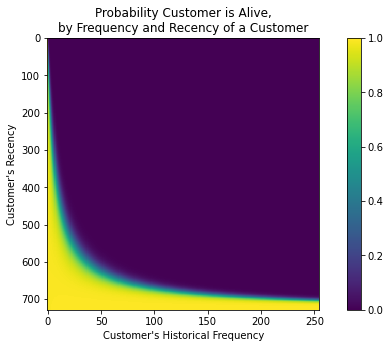

In [391]:
# now we can plot the probability
plt.rcParams['figure.figsize'] = (10,5)
lifetimes.plotting.plot_probability_alive_matrix(bgf)

In [392]:
# predict the number of transactions in the following year
summary_all['pred_frequency']=bgf.conditional_expected_number_of_purchases_up_to_time(360,summary_all['frequency'],summary_all['recency'],summary_all['T'])
summary_all.head()

,Store Number,frequency,recency,T,monetary_value,p_alive,pred_frequency
0,2106,147.0,1120.0,1121.0,1120.153197,9.997534e-01,4.618703e+01
1,2113,75.0,755.0,1123.0,106.523600,4.060480e-10,9.664861e-09
2,2130,147.0,1120.0,1121.0,1029.593741,9.997534e-01,4.618703e+01
3,2178,100.0,1078.0,1099.0,361.718400,9.978964e-01,3.214939e+01
4,2190,292.0,1121.0,1121.0,234.979110,9.998889e-01,9.120875e+01


In [393]:
# add store segments
summary_seg = pd.merge(summary_all,segments[['Store Number','Store Segment']],on=['Store Number'],how='left')
summary_seg.head()

,Store Number,frequency,recency,T,monetary_value,p_alive,pred_frequency,Store Segment
0,2106,147.0,1120.0,1121.0,1120.153197,9.997534e-01,4.618703e+01,High
1,2113,75.0,755.0,1123.0,106.523600,4.060480e-10,9.664861e-09,Medium
2,2130,147.0,1120.0,1121.0,1029.593741,9.997534e-01,4.618703e+01,High
3,2178,100.0,1078.0,1099.0,361.718400,9.978964e-01,3.214939e+01,Medium
4,2190,292.0,1121.0,1121.0,234.979110,9.998889e-01,9.120875e+01,High


In [394]:
summary_seg.shape

(1864, 8)

In [395]:
summary_all.shape

(1864, 7)

[Text(0.5, 0, 'Predicted Alive Probability'),
 Text(0, 0.5, 'Actual Transactions'),
 Text(0.5, 1.0, 'Actual Transactions (2018-2021)')]

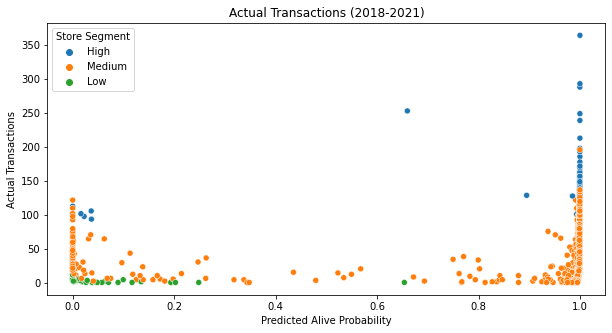

In [396]:
fig=sns.scatterplot(summary_seg['p_alive'],summary_seg['frequency'],hue=summary_seg['Store Segment'])
fig.set(xlabel='Predicted Alive Probability', ylabel='Actual Transactions',title='Actual Transactions (2018-2021)')

[Text(0.5, 0, 'Predicted Alive Probability'),
 Text(0, 0.5, 'Predicted Transactions'),
 Text(0.5, 1.0, 'Predicted in the Following Year')]

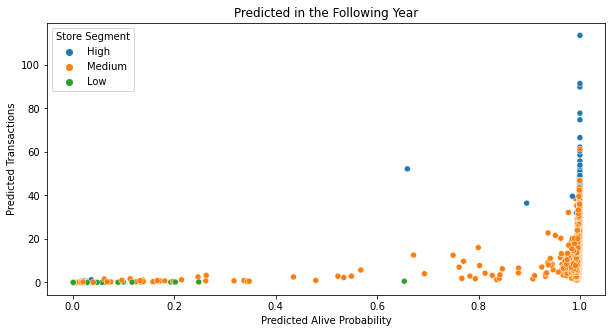

In [397]:
fig=sns.scatterplot(summary_seg['p_alive'],summary_seg['pred_frequency'],hue=summary_seg['Store Segment'])
fig.set(xlabel='Predicted Alive Probability', ylabel='Predicted Transactions',title='Predicted in the Following Year')

In [398]:
# create a column for inactive days
summary_seg['inactive']=summary_seg['T']-summary_seg['recency']

In [399]:
# Find the stores in the High segments that have low alive probability
HighDead=summary_seg.loc[(summary_seg['p_alive'] <= 0.1) & (summary_seg['Store Segment']=='High')].sort_values(by=['inactive'],ascending=False)
HighDead

,Store Number,frequency,recency,T,monetary_value,p_alive,pred_frequency,Store Segment,inactive
460,4167,102.0,725.0,1123.0,2016.373725,3.101399e-16,9.977511e-15,High,398.0
337,3869,113.0,925.0,1108.0,297.399735,6.929293e-06,2.497749e-04,High,183.0
219,3447,98.0,993.0,1122.0,4903.743673,2.257974e-02,6.990204e-01,High,129.0
223,3477,94.0,992.0,1120.0,3944.452340,3.693394e-02,1.099461e+00,High,128.0
229,3524,102.0,994.0,1122.0,4598.916471,1.626177e-02,5.236084e-01,High,128.0
1066,5124,106.0,1007.0,1123.0,770.884906,3.649437e-02,1.219306e+00,High,116.0


In [400]:
# Find the stores in the medium segments that have low alive probability (90 stores)
MediumDead=summary_seg.loc[(summary_seg['p_alive'] <= 0.1) & (summary_seg['Store Segment']=='Medium')].sort_values(by=['inactive'],ascending=False)
MediumDead

,Store Number,frequency,recency,T,monetary_value,p_alive,pred_frequency,Store Segment,inactive
304,3778,23.0,298.0,1121.0,80.812609,3.138463e-11,2.415871e-10,Medium,823.0
14,2448,39.0,308.0,1116.0,289.713333,4.141208e-19,5.267843e-18,Medium,808.0
318,3819,32.0,315.0,1120.0,256.511250,3.036861e-15,3.189078e-14,Medium,805.0
12,2327,17.0,280.0,1085.0,54.736471,2.820843e-08,1.698619e-07,Medium,805.0
908,4864,29.0,308.0,1108.0,205.071724,7.499811e-14,7.251688e-13,Medium,800.0
...,...,...,...,...,...,...,...,...,...
29,2514,65.0,935.0,1110.0,512.052000,3.130328e-02,6.554031e-01,Medium,175.0
699,4557,122.0,945.0,1115.0,376.505000,9.356664e-06,3.615068e-04,Medium,170.0
119,2641,71.0,949.0,1110.0,249.412958,3.548404e-02,8.096743e-01,Medium,161.0
1556,5713,68.0,560.0,711.0,254.512941,2.969513e-04,9.959192e-03,Medium,151.0


In [401]:
# Find the stores in the high segments that have high alive probability
summary_seg.loc[(summary_seg['p_alive'] >= 0.5) & (summary_seg['Store Segment']=='High')].sort_values(by=['inactive'],ascending=False)

,Store Number,frequency,recency,T,monetary_value,p_alive,pred_frequency,Store Segment,inactive
242,3612,129.0,1064.0,1117.0,215.950310,0.894777,36.462441,High,53.0
115,2633,253.0,1084.0,1121.0,8794.354387,0.659693,52.188247,High,37.0
272,3691,128.0,1087.0,1123.0,867.891094,0.985191,39.633994,High,36.0
65,2567,101.0,1080.0,1114.0,885.557030,0.993204,31.891780,High,34.0
775,4677,53.0,939.0,969.0,5548.702642,0.997020,19.522916,High,30.0
...,...,...,...,...,...,...,...,...,...
122,2644,130.0,1115.0,1115.0,1790.280154,0.999756,41.123076,High,0.0
22,2505,163.0,1075.0,1075.0,642.716503,0.999804,53.270619,High,0.0
23,2506,159.0,1116.0,1116.0,1635.378050,0.999799,50.130508,High,0.0
525,4291,102.0,1120.0,1120.0,497.633431,0.999692,32.244430,High,0.0


In [402]:
# Find the stores in the medium segments that have high alive probability
summary_seg.loc[(summary_seg['p_alive'] >= 0.5) & (summary_seg['Store Segment']=='Medium')].sort_values(by=['inactive'],ascending=False)

,Store Number,frequency,recency,T,monetary_value,p_alive,pred_frequency,Store Segment,inactive
1031,5076,2.0,293.0,856.0,23.755000,0.835959,1.274637,Medium,563.0
1360,5503,5.0,555.0,1094.0,167.288000,0.793649,1.712719,Medium,539.0
1181,5277,5.0,545.0,1024.0,154.860000,0.840969,1.934622,Medium,479.0
754,4647,3.0,448.0,920.0,56.910000,0.906997,1.631438,Medium,472.0
1167,5261,10.0,714.0,1096.0,155.196000,0.782969,2.929473,Medium,382.0
...,...,...,...,...,...,...,...,...,...
1582,5740,30.0,630.0,630.0,210.424000,0.999069,17.117894,Medium,0.0
326,3833,108.0,1117.0,1117.0,269.195000,0.999709,34.197548,Medium,0.0
325,3831,94.0,1107.0,1107.0,171.618511,0.999668,30.096326,Medium,0.0
324,3830,119.0,1120.0,1120.0,315.871765,0.999734,37.527221,Medium,0.0


The predicted probabilities along with the predicted segements will be used:
- to identify the profitable, highly-profitable and non-profitable stores
- to optimize the acqusition spending (spend more on marketing campaigns at highly profitable stores and less on low profitable stores)
- to measure the impact of a marketing campaign (repeat the same stratigies for highly profitable stores, or change the strategy for low profitable stores)

We can get the Customer Lifetime Value by predicting the sales using Gamma-Gamma model. However, The frequency and the monetary value are moderately correalated and this model my not be accurate enough.

In [95]:
# check if the frequency and the monetary value are correlated in the test set
summary[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.444004
monetary_value,0.444004,1.000000


In [405]:
segments.shape

(2079, 5)